In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import datetime
import calendar
from geopy.geocoders import Nominatim
from staticmap import StaticMap, CircleMarker, Line, Polygon
import overpy
import matplotlib.pyplot as plt
from math import radians, cos, sin, asin, sqrt
import unidecode
from haversine import haversine
from collections import defaultdict

## Functions

##### Geolocalisation

In [2]:
def get_city(coord : iter):
    """Documentation
    Parameters: 
        coord: tuple of gps coordinates (longitude, latitude)
    Out:
        dictionnary of the address of the location
    """
    lat = coord[1]
    lon = coord[0]
    nominatim = Nominatim(user_agent = 'my-application')
    r = nominatim.reverse(str(lat) + ',' + str(lon))
    return r.raw['address']

In [3]:
def select_city_postal(address : dict):
    """Documntation
    Parameters:
        address: dictionnary of the address of a location
    Out:
        name and post code of the location
    """
    if 'village' in address.keys():
        return address['village'], address['postcode']
    else:
        return address['city'], address['postcode']

##### Weather with 'meteofrance'

In [4]:
def find_insee(city, postal):
    """Documentation
    Parameters:
        city: name of a city
        postal: post code of a city
    Out:
        insee code of this city
    """
    insee = pd.read_csv('./../data/code_insee.csv', sep = ';')
    insee = insee[insee['Commune'] == city.upper()]
    assert len(insee) > 0, "Aucune commune ne correspond à cette recherche"
    code = insee['Code INSEE'][insee['Code Postal'].str.contains(str(postal))].values[0]
    
#     if len(code) > 1:
#         for line in code:
#             print(line[2:5])
#         choice = int(input("Choisissez celui que vous voulez (entre 1 et " + str(len(code)) + ", autre pour annuler)"))
#         if choice not in set(range(1,len(code))):
#             print("Fonction annulée")
#             return 0
#         code = code[choice - 1][0]
#     else:
#         code = code[0][0]
    return code

In [5]:
def get_meteo(insee, day):
    """Documentation
    Parameters:
        insee: insee code of a city
        day: day in format dd-mm-yy
    Out:
        dictionnary of the weather
    """
    lieu_type = 'VILLE_FRANCE'
    
    url = "http://www.meteofrance.com/climat/meteo-date-passee?lieuId=" + insee + "0&lieuType=" + lieu_type + "&date=" + day
    
    page = requests.get(url)
    assert page.status_code == 200, "Error loading the webpage"
    
    today = datetime.date.today()
    day = datetime.datetime.strptime(day, '%d-%m-%Y').date()
    limite = datetime.datetime.strptime('01-01-1963', '%d-%m-%Y').date()
    assert day < today and day > limite, "Wrong date (Need between 01-01-1963 and " + datetime.date.today().strftime('%d-%m-%Y') + ")"
    
    soup = BeautifulSoup(page.content, 'html.parser')
    liste_info_journee = soup.find_all('ul', class_='grid-half')
#     liste_horaires = soup.find_all('div', class_="grid-half echeances")
    
    if liste_info_journee:
        liste_info_journee = liste_info_journee[0].find_all('li')
#     if liste_horaires:
#         liste_horaires = liste_horaires[0].find_all('dl')
    
    res = liste_info_journee # + liste_horaires
#     for i in res:
#         print(i.get_text().strip())
    dic = {}
    for result in res:
        kv = result.get_text().split(':')
        key = kv[0].strip()
        value = kv[1].strip()
        tokeep = ''
        for i in value:
            if i.isdigit() or i == '.':
                tokeep += i
        dic[key] = float(tokeep)
    return dic

In [6]:
def get_meteo_monthly(insee, month, year):
    """Documentation
    Parameters:
        insee: insee code of a city
        month: month in integer
        year: year in integer
    Out:
        dictionnary of the weather for the month
    """
    nb_days = calendar.monthrange(year, month)[1]
    mean_d = {}
    list_min_temp = []
    list_max_temp = []
    list_soleil = []
    list_pluie = []
    for day in range(1, nb_days + 1):
        date = str(day) + '-' + str(month) + '-' + str(year)
        d = get_meteo(insee, date)
        
        list_min_temp.append(d['Température minimale de la journée'])
        list_max_temp.append(d['Température maximale de la journée'])
        list_soleil.append(d["Durée d'ensoleillement de la journée"])
        list_pluie.append(d['Hauteur des précipitations'])
        
    mean_d['Température maximale du mois'] = max(list_max_temp)
    mean_d['Température minimale du mois'] = min(list_min_temp)
    mean_d['Température minimale moyenne'] = sum(list_min_temp) / len(list_min_temp)
    mean_d['Température maximale moyenne'] = sum(list_max_temp) / len(list_max_temp)

    mean_d['Hauteur minimale des précipitations'] = min(list_pluie)
    mean_d['Hauteur maximale des précipitations'] = max(list_pluie)
    mean_d['Hauteur moyenne des précipitations'] = sum(list_pluie) / len(list_pluie)
    
    mean_d["Durée maximale d'ensoleillement"] = max(list_soleil)
    mean_d["Durée minimale d'ensoleillement"] = min(list_soleil)
    mean_d["Durée d'ensoleillement moyenne"] = sum(list_soleil) / len(list_soleil)

    return mean_d

In [7]:
def estimate_meteo_year(insee, year):
    """Documentation
    Parameters:
        insee: insee code of a city
        year: year in integer
    Out:
        dictionnary with the weather for the year
    """
    days = ['01', '06', '11', '16', '21', '26']
    months = ["{0:0=2d}".format(i) for i in range(1, 13)]
    mean_d = {}
    list_min_temp = []
    list_max_temp = []
    list_soleil = []
    list_pluie = []
    for m in months:
        for d in days:
            date = d + '-' + m + '-' + str(year)
            dic = get_meteo(insee, date)
            
            list_min_temp.append(dic['Température minimale de la journée'])
            list_max_temp.append(dic['Température maximale de la journée'])
            list_soleil.append(dic["Durée d'ensoleillement de la journée"])
            list_pluie.append(dic['Hauteur des précipitations'])
    
    mean_d["Température maximale de l'année"] = max(list_max_temp)
    mean_d["Température minimale de l'année"] = min(list_min_temp)
    mean_d["Température minimale moyenne"] = sum(list_min_temp) / len(list_min_temp)
    mean_d["Température maximale moyenne"] = sum(list_max_temp) / len(list_max_temp)

    mean_d['Hauteur minimale des précipitations'] = min(list_pluie)
    mean_d['Hauteur maximale des précipitations'] = max(list_pluie)
    mean_d['Hauteur moyenne des précipitations'] = sum(list_pluie) / len(list_pluie)
    
    mean_d["Durée maximale d'ensoleillement"] = max(list_soleil)
    mean_d["Durée minimale d'ensoleillement"] = min(list_soleil)
    mean_d["Durée d'ensoleillement moyenne"] = sum(list_soleil) / len(list_soleil)
    
    return mean_d

##### Weather with 'historique_meteo'

In [8]:
def assign_old_state(code):
    """Documentation
    Parameters:
        code: first two digits of a postcode
    Out:
        reg: state for this city in historique_meteo website
    """
    regions = {
        "alsace": ['67', '68'],
        "aquitaine": ['24', '33', '40', '47', '64'],
        "ardeche": ['07'],
        "auvergne": ['03', '15', '43', '63'],
        "bourgogne": ['21', '58', '71', '89'],
        "bretagne": ['22', '29', '35', '56'],
        "centre": ['18', '28', '36', '37', '41', '45'],
        "champagne-ardenne": ['08', '10', '51', '52'],
        "corse": ['20', '2A', '2B'],
        "franche-comte": ['25', '70', '39', '90'],
        "ile-de-re": ['17'],
        "ile-de-france": ['75', '77', '78', '91', '92', '93', '94', '95'],
        "languedoc-roussillon": ['11', '30', '34', '48', '66'],
        "limousin": ['19', '23', '87'],
        "lorraine": ['54', '55', '57', '88'],
        "midi-pyrenees": ['09', '12', '31', '32', '65', '46', '81', '82'],
        "nord-pas-de-calais": ['59', '62'],
        "normandie": ['14', '27', '50', '61', '76'],
        "pays-de-la-loire": ['44', '49', '53', '72', '85'],
        "picardie": ['02', '60', '80'],
        "poitou-charentes": ['16', '79', '86'],
        "provence-alpes-c-te-d-azur": ['04', '05', '06', '13', '83', '84'],
        "rh-ne-alpes": ['01', '26', '38', '42', '69', '73', '74']
    }
    for reg, list_code in regions.items():
        if code in list_code:
            return reg
    print('Code must be between 01 and 95')
    return 0

In [9]:
def check_city(coord, reg, city):
    """Documentation
    Parameters:
        coord: tuple of gps coordinates (longitude, latitude)
        reg: state in historique_meteo website
        city: name of a city
    Out:
        city_url: url of the city in historique_meteo website
        city: name of the city
    """
    lon = coord[0]
    lat = coord[1]
    df = pd.read_csv('./../data/historique_meteo.csv', converters = {'villes': eval, 'villes_url': eval, 'coordinates (lat,lon)': eval})
    city = city.lower()
    location = (lat, lon)
    
    if city in df[df['region_url'] == reg]['villes'].values[0]:
        idx = df[df['region_url'] == reg]['villes'].values[0].index(city)
        city_url = df[df['region_url'] == reg]['villes_url'].values[0][idx]
    else:
        dist = []
        for coord in df[df['region_url'] == reg]['coordinates (lat,lon)'].values[0]:
            dist.append(haversine(coord, location, unit = 'm'))
        idx = dist.index(min(dist))
        city_url = df[df['region_url'] == reg]['villes_url'].values[0][idx]
        city = df[df['region_url'] == reg]['villes'].values[0][idx]
    return city_url, city

In [10]:
def get_historique_meteo(coord, year, month=None):
    """Documentation
    Parameters:
        coord: tuple of gps coordinates (longitude, latitude)
        year: year for the weather in integer
        month: month for the weather in integer
    Out:
        res: dictionnary of the weather
    """
    lon = coord[0]
    lat = coord[1]
    address = get_city(coord)
    city, postal = select_city_postal(address)
    region_url = assign_old_state(postal[0:2])
    city_url, city = check_city(coord, region_url, city)

    now = datetime.datetime.now()
    assert (int(year) >= 2009) & (int(year) <=
                                  now.year), "The year must be between 2009 and " + str(now.year)
    year = str(year)

    if month != None:
        if year == now.year:
            assert (int(month) >= 0) & (
                int(month) <= now.month), "The month must be between 0 and " + str(now.month)
        else:
            assert (int(month) >= 0) & (int(month) <=
                                        12), "The month must be between 0 and 12"
        month = "{0:0=2d}".format(month)
        url = 'https://www.historique-meteo.net/france/{0}/{1}/{2}/{3}'
        url = url.format(region_url, city_url, year, month)
        res = scrap_historique_meteo(url)

    else:
        if year == now.year:
            range_month = now.month
        else:
            range_month = 13

        res = defaultdict(list)

        for month in range(1, range_month):
            month_2d = "{0:0=2d}".format(month)
            url = 'https://www.historique-meteo.net/france/{0}/{1}/{2}/{3}'
            url = url.format(region_url, city_url, year, month_2d)
            dic = scrap_historique_meteo(url)
            for k, v in dic.items():
                res[k].append(v)

        mean_list = ['Température moyenne (°C)', 
                     'Température maximale (°C)',
                     'Température minimale (°C)', 
                     'Vitesse du vent (km/h)', 
                     'Température du vent (°C)', 
                     'Précipitations moyennes par jour (mm)',
                     'Précipitations totales sur le mois (mm)',
                     'Humidité (%)',
                     'Visibilité (km)',
                     'Couverture nuageuse (%)',
                     'Indice de chaleur',
                     'Point de rosée (°C)',
                     'Pression (hPa)']
        max_list = ['Température maximale record (°C)', 'Record de précipitations sur une journée (mm)']
        min_list = ['Température minimale record (°C)']
        mean_time = ['Heure du lever du soleil', 'Heure du coucher du soleil', 'Durée du jour']
#         print(res)
        for key in mean_list:
            res[key] = np.mean(res[key])
        for key in max_list:
            res[key] = max(res[key])
        for key in min_list:
            res[key] = min(res[key])
        for key in mean_time:
            m = np.mean(list(map(lambda f: (((f.hour * 60) + f.minute) * 60) + f.second, res[key])))
            res[key] = datetime.datetime.strptime(str(datetime.timedelta(seconds = m)), '%H:%M:%S').time()

    res['Ville'] = city
    return dict(res)

In [11]:
def scrap_historique_meteo(url):
    """Documentation
    Parameters:
        url: url for historique_meteo website
    Out:
        dic: dictionnary of the weather
    """
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    tableau = soup.find_all('tbody')[0]
    keys = tableau.find_all('td', class_ = None)[:-1]
    values = tableau.find_all('b')
    assert len(keys) == len(values), 'Wrong selection of the data'
    
    dic = {}
    
    for i in range(len(keys)):
        value = values[i].get_text().strip()
        tokeep = ''
        for char in value:
            if char.isdigit() or char == '.' or char == ':':
                tokeep += char
        if ':' in tokeep:
            tokeep = datetime.datetime.strptime(tokeep, '%H:%M:%S').time()
        else:
            tokeep = float(tokeep)
        
        pos = next(i for i,j in list(enumerate(value, 1))[::-1] if j.isdigit())
        unity = value[pos:]
        if unity == '°':
            unity += 'C'
        
        if unity != '':
            key = keys[i].get_text().strip() + ' (' + str(unity) + ')'
        else :
            key = keys[i].get_text().strip()
        
        dic[key] = tokeep
    return dic

##### Street and satellite views

In [12]:
def get_plan(coord, dist, style='plan', width = 200, height = 400):
    """Documentation
    Parameters:
        coord: tuple of gps coordinates (longitude, latitude)
        dist: 
        style: style of the static map in (plan, sat)
        width: width of the image
        height: height of the image
    Out:
        static map arround the gps coordinates
    """
    if style == 'plan':
        # zoom : [1; 20]
        url_temp = 'http://c.tiles.wmflabs.org/osm-no-labels/{z}/{x}/{y}.png'
    elif style == 'sat':
        # zoom : [1; 19]
        # bounds: [[-75, -180], [81, 180]]
        url_temp = 'https://wxs.ign.fr/choisirgeoportail/geoportail/wmts?REQUEST=GetTile&SERVICE=WMTS&VERSION=1.0.0&STYLE=normal&TILEMATRIXSET=PM&FORMAT=image/jpeg&LAYER=ORTHOIMAGERY.ORTHOPHOTOS&TILEMATRIX={z}&TILEROW={y}&TILECOL={x}'
    

    
    m = StaticMap(width, height, url_template=url_temp, tile_size = 256)
    marker = CircleMarker(coord, 'red', 5)  # longitude, latitude
    m.add_marker(marker)
    zoom = 19
    return m.render(zoom = zoom)

##### Queries to search what is around

In [13]:
def search_around(coord, tag, dist):
    lon = coord[0]
    lat = coord[1]
    api = overpy.Overpass()
    q = """
        (
        node(around:{0},{1},{2})["{3}"];
        way(around:{0},{1},{2})["{3}"];
        rel(around:{0},{1},{2})["{3}"];
        area(around:{0},{1},{2})["{3}"];
        );
        out;
        """
    q = q.format(dist, lat, lon, tag)
    r = api.query(q)
    return r

##### Elevation

In [14]:
def get_elevation(coord):
    lon = coord[0]
    lat = coord[1]
    url = "https://api.opentopodata.org/v1/eudem25m?locations={0},{1}"
    url = url.format(lat, lon)
    page = requests.get(url).json()
    if page['status'] == 'OK':
        return page['results'][0]['elevation']
    else:
        print('The request did not work')
        return -10000

In [15]:
def get_elevation_fr(coord):
    lon = coord[0]
    lat = coord[1]
    query = 'http://wxs.ign.fr/choisirgeoportail/alti/rest/elevation.json?lon={0}&lat={1}&zonly=true'
    if type(lat) == list:
        assert len(lat) == len(lon), "Latitudes and longitude must have the same length"
        for i in range(len(lat)):
            list_lon = '|'.join(map(str, lon))
            list_lat = '|'.join(map(str, lat))
        q = query.format(list_lon, list_lat)
    else:
        q = query.format(lon, lat)
    r = requests.get(q)
    dic = r.json()
    return dic['elevations']

##### Save

In [16]:
def to_json(dic, path, sort = True):
    with open(path, 'w') as fp:
        json.dump(dic, fp, sort_keys=sort, indent=4)

## Sequencing of functions

In [74]:
gps1 = (1.465923, 43.561646)
gps2 = (0.5, 47.47)

In [75]:
a = get_city(gps1)
a

{'amenity': 'Université Paul Sabatier - Toulouse III',
 'road': 'Impasse Henri-Dominique Lacordaire',
 'neighbourhood': 'Rangueil, Sauzelong, Pech David, Pouvourville',
 'suburb': 'Toulouse Sud-Est',
 'city': 'Toulouse',
 'municipality': 'Toulouse',
 'county': 'Haute-Garonne',
 'state': 'Occitanie',
 'country': 'France',
 'postcode': '31400',
 'country_code': 'fr'}

In [76]:
b = get_city(gps2)
b

{'place': "Rond de l'Âne",
 'village': 'Ambillou',
 'municipality': 'Chinon',
 'county': 'Indre-et-Loire',
 'state': 'Centre-Val de Loire',
 'country': 'France',
 'postcode': '37340',
 'country_code': 'fr'}

In [17]:
get_city((1.8, 44))

{'isolated_dwelling': 'Bondes',
 'village': 'Sainte-Cécile-du-Cayrou',
 'municipality': 'Albi',
 'county': 'Tarn',
 'state': 'Occitanie',
 'country': 'France',
 'postal_code': '81140',
 'country_code': 'fr'}

In [77]:
select_city_postal(a)

('Toulouse', '31400')

In [78]:
select_city_postal(b)

('Ambillou', '37340')

In [79]:
find_insee('toulouse', '31400')

'31555'

In [80]:
get_meteo('31555', '07-05-2019')

{'Température minimale de la journée': 4.7,
 'Température maximale de la journée': 22.3,
 "Durée d'ensoleillement de la journée": 7.0,
 'Hauteur des précipitations': 0.4}

In [81]:
get_meteo_monthly('31555', 10, 2006)

{'Température maximale du mois': 26.2,
 'Température minimale du mois': 7.0,
 'Température minimale moyenne': 13.764516129032259,
 'Température maximale moyenne': 21.603225806451615,
 'Hauteur minimale des précipitations': 0.0,
 'Hauteur maximale des précipitations': 68.6,
 'Hauteur moyenne des précipitations': 2.8064516129032264,
 "Durée maximale d'ensoleillement": 11.0,
 "Durée minimale d'ensoleillement": 0.0,
 "Durée d'ensoleillement moyenne": 5.161290322580645}

In [91]:
estimate_meteo_year('31555', 2010)

{"Température maximale de l'année": 40.0,
 "Température minimale de l'année": 0.1,
 'Température minimale moyenne': 9.256944444444445,
 'Température maximale moyenne': 17.819444444444446,
 'Hauteur minimale des précipitations': 0.0,
 'Hauteur maximale des précipitations': 23.9,
 'Hauteur moyenne des précipitations': 1.5277777777777777,
 "Durée maximale d'ensoleillement": 15.0,
 "Durée minimale d'ensoleillement": 0.0,
 "Durée d'ensoleillement moyenne": 5.986111111111111}

In [82]:
get_historique_meteo(gps1, 2015, 5)

{'Température moyenne (°C)': 17.0,
 'Température maximale (°C)': 22.0,
 'Température minimale (°C)': 12.0,
 'Température maximale record (°C)': 30.0,
 'Température minimale record (°C)': 16.0,
 'Vitesse du vent (km/h)': 21.0,
 'Température du vent (°C)': 17.0,
 'Précipitations moyennes par jour (mm)': 1.0,
 'Record de précipitations sur une journée (mm)': 2.0,
 'Précipitations totales sur le mois (mm)': 8.0,
 'Humidité (%)': 71.0,
 'Visibilité (km)': 10.0,
 'Couverture nuageuse (%)': 44.0,
 'Indice de chaleur': 23.0,
 'Point de rosée (°C)': 13.0,
 'Pression (hPa)': 1022.0,
 'Heure du lever du soleil': datetime.time(5, 48),
 'Heure du coucher du soleil': datetime.time(20, 27),
 'Durée du jour': datetime.time(14, 39),
 'Ville': 'toulouse'}

In [83]:
get_historique_meteo(gps2, 2019)

{'Température moyenne (°C)': 12.916666666666666,
 'Température maximale (°C)': 16.916666666666668,
 'Température minimale (°C)': 8.75,
 'Température maximale record (°C)': 39.0,
 'Température minimale record (°C)': 8.0,
 'Vitesse du vent (km/h)': 19.333333333333332,
 'Température du vent (°C)': 10.5,
 'Précipitations moyennes par jour (mm)': 2.6666666666666665,
 'Record de précipitations sur une journée (mm)': 36.0,
 'Précipitations totales sur le mois (mm)': 65.25,
 'Humidité (%)': 80.0,
 'Visibilité (km)': 10.0,
 'Couverture nuageuse (%)': 49.583333333333336,
 'Indice de chaleur': 17.416666666666668,
 'Point de rosée (°C)': 10.25,
 'Pression (hPa)': 1019.4166666666666,
 'Heure du lever du soleil': datetime.time(7, 6, 10),
 'Heure du coucher du soleil': datetime.time(19, 21),
 'Durée du jour': datetime.time(12, 14, 50),
 'Ville': 'châteaux-de-la-loire'}

In [84]:
get_historique_meteo(gps1, 2015)

{'Température moyenne (°C)': 14.583333333333334,
 'Température maximale (°C)': 19.166666666666668,
 'Température minimale (°C)': 10.166666666666666,
 'Température maximale record (°C)': 37.0,
 'Température minimale record (°C)': 8.0,
 'Vitesse du vent (km/h)': 19.166666666666668,
 'Température du vent (°C)': 13.5,
 'Précipitations moyennes par jour (mm)': 1.75,
 'Record de précipitations sur une journée (mm)': 24.0,
 'Précipitations totales sur le mois (mm)': 34.0,
 'Humidité (%)': 74.83333333333333,
 'Visibilité (km)': 9.833333333333334,
 'Couverture nuageuse (%)': 39.166666666666664,
 'Indice de chaleur': 19.916666666666668,
 'Point de rosée (°C)': 11.166666666666666,
 'Pression (hPa)': 1022.6666666666666,
 'Heure du lever du soleil': datetime.time(7, 3, 20),
 'Heure du coucher du soleil': datetime.time(19, 16, 45),
 'Durée du jour': datetime.time(12, 13, 25),
 'Ville': 'toulouse'}

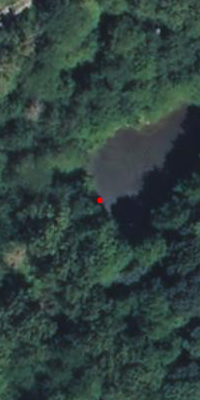

In [85]:
get_plan(gps2, 50, 'sat')

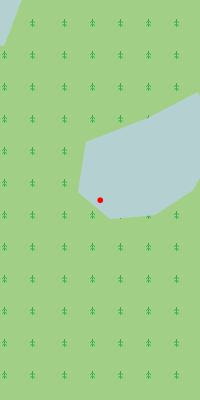

In [86]:
get_plan(gps2, 50)

In [25]:
a = search_around(gps2, "natural", 100)

In [87]:
get_elevation(gps2)

87.78816986083984

In [88]:
get_elevation_fr(gps2)

[81.93]

## Function "main"

In [89]:
def main(coord, dist, year_meteo):
    elevation = get_elevation(coord)
    plan = get_plan(coord, dist)
    sat = get_plan(coord, dist, style='sat')
    city, postal = select_city_postal(get_city(coord))
    code = find_insee(city, postal)
    meteo_mf = estimate_meteo_year(code, year_meteo)
    meteo_hm = get_historique_meteo(coord, year_meteo)
    dic = {}
    dic['elevation'] = elevation
    dic['img_plan'] = plan
    dic['img_sat'] = sat
    dic['weather (meteofrance)'] = meteo_mf
    dic['weather (historique_meteo)'] = meteo_hm
    return dic

In [90]:
result = main(gps2, 50, 2019)
result

{'elevation': 87.78816986083984,
 'img_plan': <PIL.Image.Image image mode=RGB size=200x400 at 0x1D5A2306208>,
 'img_sat': <PIL.Image.Image image mode=RGB size=200x400 at 0x1D5A1E86F98>,
 'weather (meteofrance)': {"Température maximale de l'année": 34.9,
  "Température minimale de l'année": 0.1,
  'Température minimale moyenne': 8.848611111111108,
  'Température maximale moyenne': 17.91805555555555,
  'Hauteur minimale des précipitations': 0.0,
  'Hauteur maximale des précipitations': 21.6,
  'Hauteur moyenne des précipitations': 1.8680555555555556,
  "Durée maximale d'ensoleillement": 15.0,
  "Durée minimale d'ensoleillement": 0.0,
  "Durée d'ensoleillement moyenne": 5.708333333333333},
 'weather (historique_meteo)': {'Température moyenne (°C)': 12.916666666666666,
  'Température maximale (°C)': 16.916666666666668,
  'Température minimale (°C)': 8.75,
  'Température maximale record (°C)': 39.0,
  'Température minimale record (°C)': 8.0,
  'Vitesse du vent (km/h)': 19.333333333333332,
 

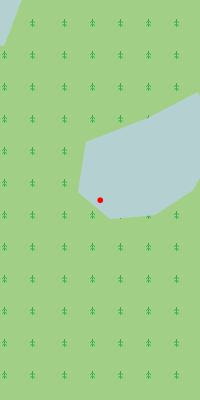

In [109]:
result['img_plan']

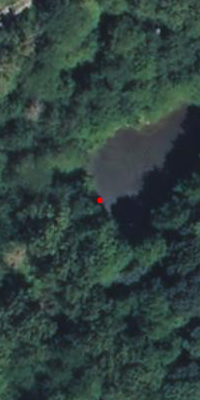

In [110]:
result['img_sat']

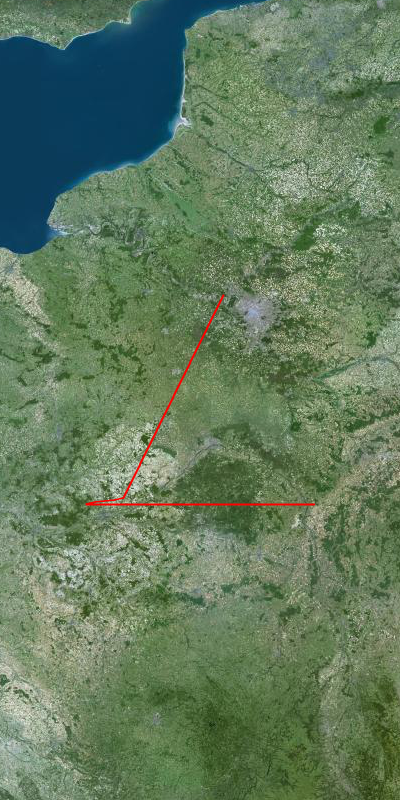

In [18]:
ex = [(47.47, 0.5), (47.48, 0.6), (47.49, 0.7), (47.50, 0.8), (47.51, 0.9)]
ex2 = [(0.5, 47.47), (0.6, 47.48), (0.7, 47.49), (0.8, 47.50), (0.9, 47.51), (2, 49)]
ex3 = [(0.5, 47.47), (1, 47.47), (1.5, 47.47), (2, 47.47), (2.5, 47.47), (3, 47.47)]
ex2.reverse()

url_temp = 'https://wxs.ign.fr/choisirgeoportail/geoportail/wmts?REQUEST=GetTile&SERVICE=WMTS&VERSION=1.0.0&STYLE=normal&TILEMATRIXSET=PM&FORMAT=image/jpeg&LAYER=ORTHOIMAGERY.ORTHOPHOTOS&TILEMATRIX={z}&TILEROW={y}&TILECOL={x}'
m = StaticMap(400, 800, url_template=url_temp, tile_size = 256)
# for i in range(len(ex) - 1):
# line = Line(ex2, 'blue', 5)
# line2 = Line(ex3, 'red', 5)
poly = Line(ex2 + ex3, 'red', 2)
m.add_line(poly)
m.render()